In [ ]:
import sys

sys.path.append("..")

### Test

In [ ]:
import os
from typing import List, Dict
from pathlib import Path
from PIL import Image
from segment.utils import resize_image_pil
from segment.dino_script import get_dino_results
from segment.sam_script import get_sam_results
from segment.utils import get_device
from segment.sam_results import SAMResults
from diffusers.utils import load_image
from segment.sam_script import get_sam_results
from segment.utils import get_coco_style_polygons
import yaml
from datasets import load_dataset

os.environ["TOKENIZERS_PARALLELISM"] = "true"


# Function for resizing an image to a specific size without changing the aspect ratio
def load_resize_image(image_path: str | Image.Image, size: int) -> Image.Image:
    if isinstance(image_path, str):
        image_pil = load_image(image_path).convert("RGB")
    else:
        image_pil = image_path.convert("RGB")

    image_pil = resize_image_pil(image_pil, size)
    return image_pil


# Simple function for getting the masks based on a prompt
def get_masks(
    text_prompt,
    image_paths: List[str | Image.Image],
    labels_dict: Dict[str, int],
    size: int = 1024,
    **kwargs,
) -> SAMResults:
    device = get_device()

    assert bool(image_paths), "No images provided"

    # Load and resize the images
    images = [load_resize_image(im, size) for im in image_paths]

    # Get the boxes from the prompts using DINO
    dino_results = get_dino_results(images, text_prompt, device, **kwargs)

    # Get the masks from the images and boxes using SAM
    unformatted_results = get_sam_results(images, dino_results, text_prompt, device)

    sam_results = SAMResults(
        images[0], labels_dict, **unformatted_results[0], person_masks_only=False
    )
    return sam_results


# loading yaml config file
def load_yaml(path):
    with open(path, "r") as file:
        data = yaml.load(file, Loader=yaml.FullLoader)
    return data


# Get the labels dictionary from the config file
def get_labels_dict(config_path):
    data = load_yaml(config_path)
    labels_dict = data.get("names")
    labels_dict = {v: k for k, v in labels_dict.items()}
    return labels_dict

In [ ]:
# Set the cache dir
cache_dir = "hf_cache"

# Torch Settings
batch_size = 8
num_workers = os.cpu_count()
device = get_device()

# Get the labels from the yolo config file
config_path = "configs/fashion_people_detection_no_person.yml"

# Get the labels from the config file
labels_dict = get_labels_dict(config_path)
labels = [k for k, v in labels_dict.items()]
text_prompt = " . ".join(labels)
print(f"Labels To Use: {text_prompt}")

# Enter the dataset ID and load it as a torch dataset
dataset_id = "MnLgt/fashion_num_people"
split = "train[:100]"

# Enter the repo name to push the new dataset to
new_repo_id = "jordandavis/fashion_people_detections"

In [ ]:
ds = load_dataset(
    dataset_id,
    split='train',
    trust_remote_code=True,
    cache_dir="hf_cache",
    streaming=True,
)

In [ ]:
rows = iter(ds)

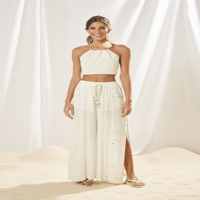

In [24]:
row = next(rows)
image = row.get('image')
image.resize((200,200))

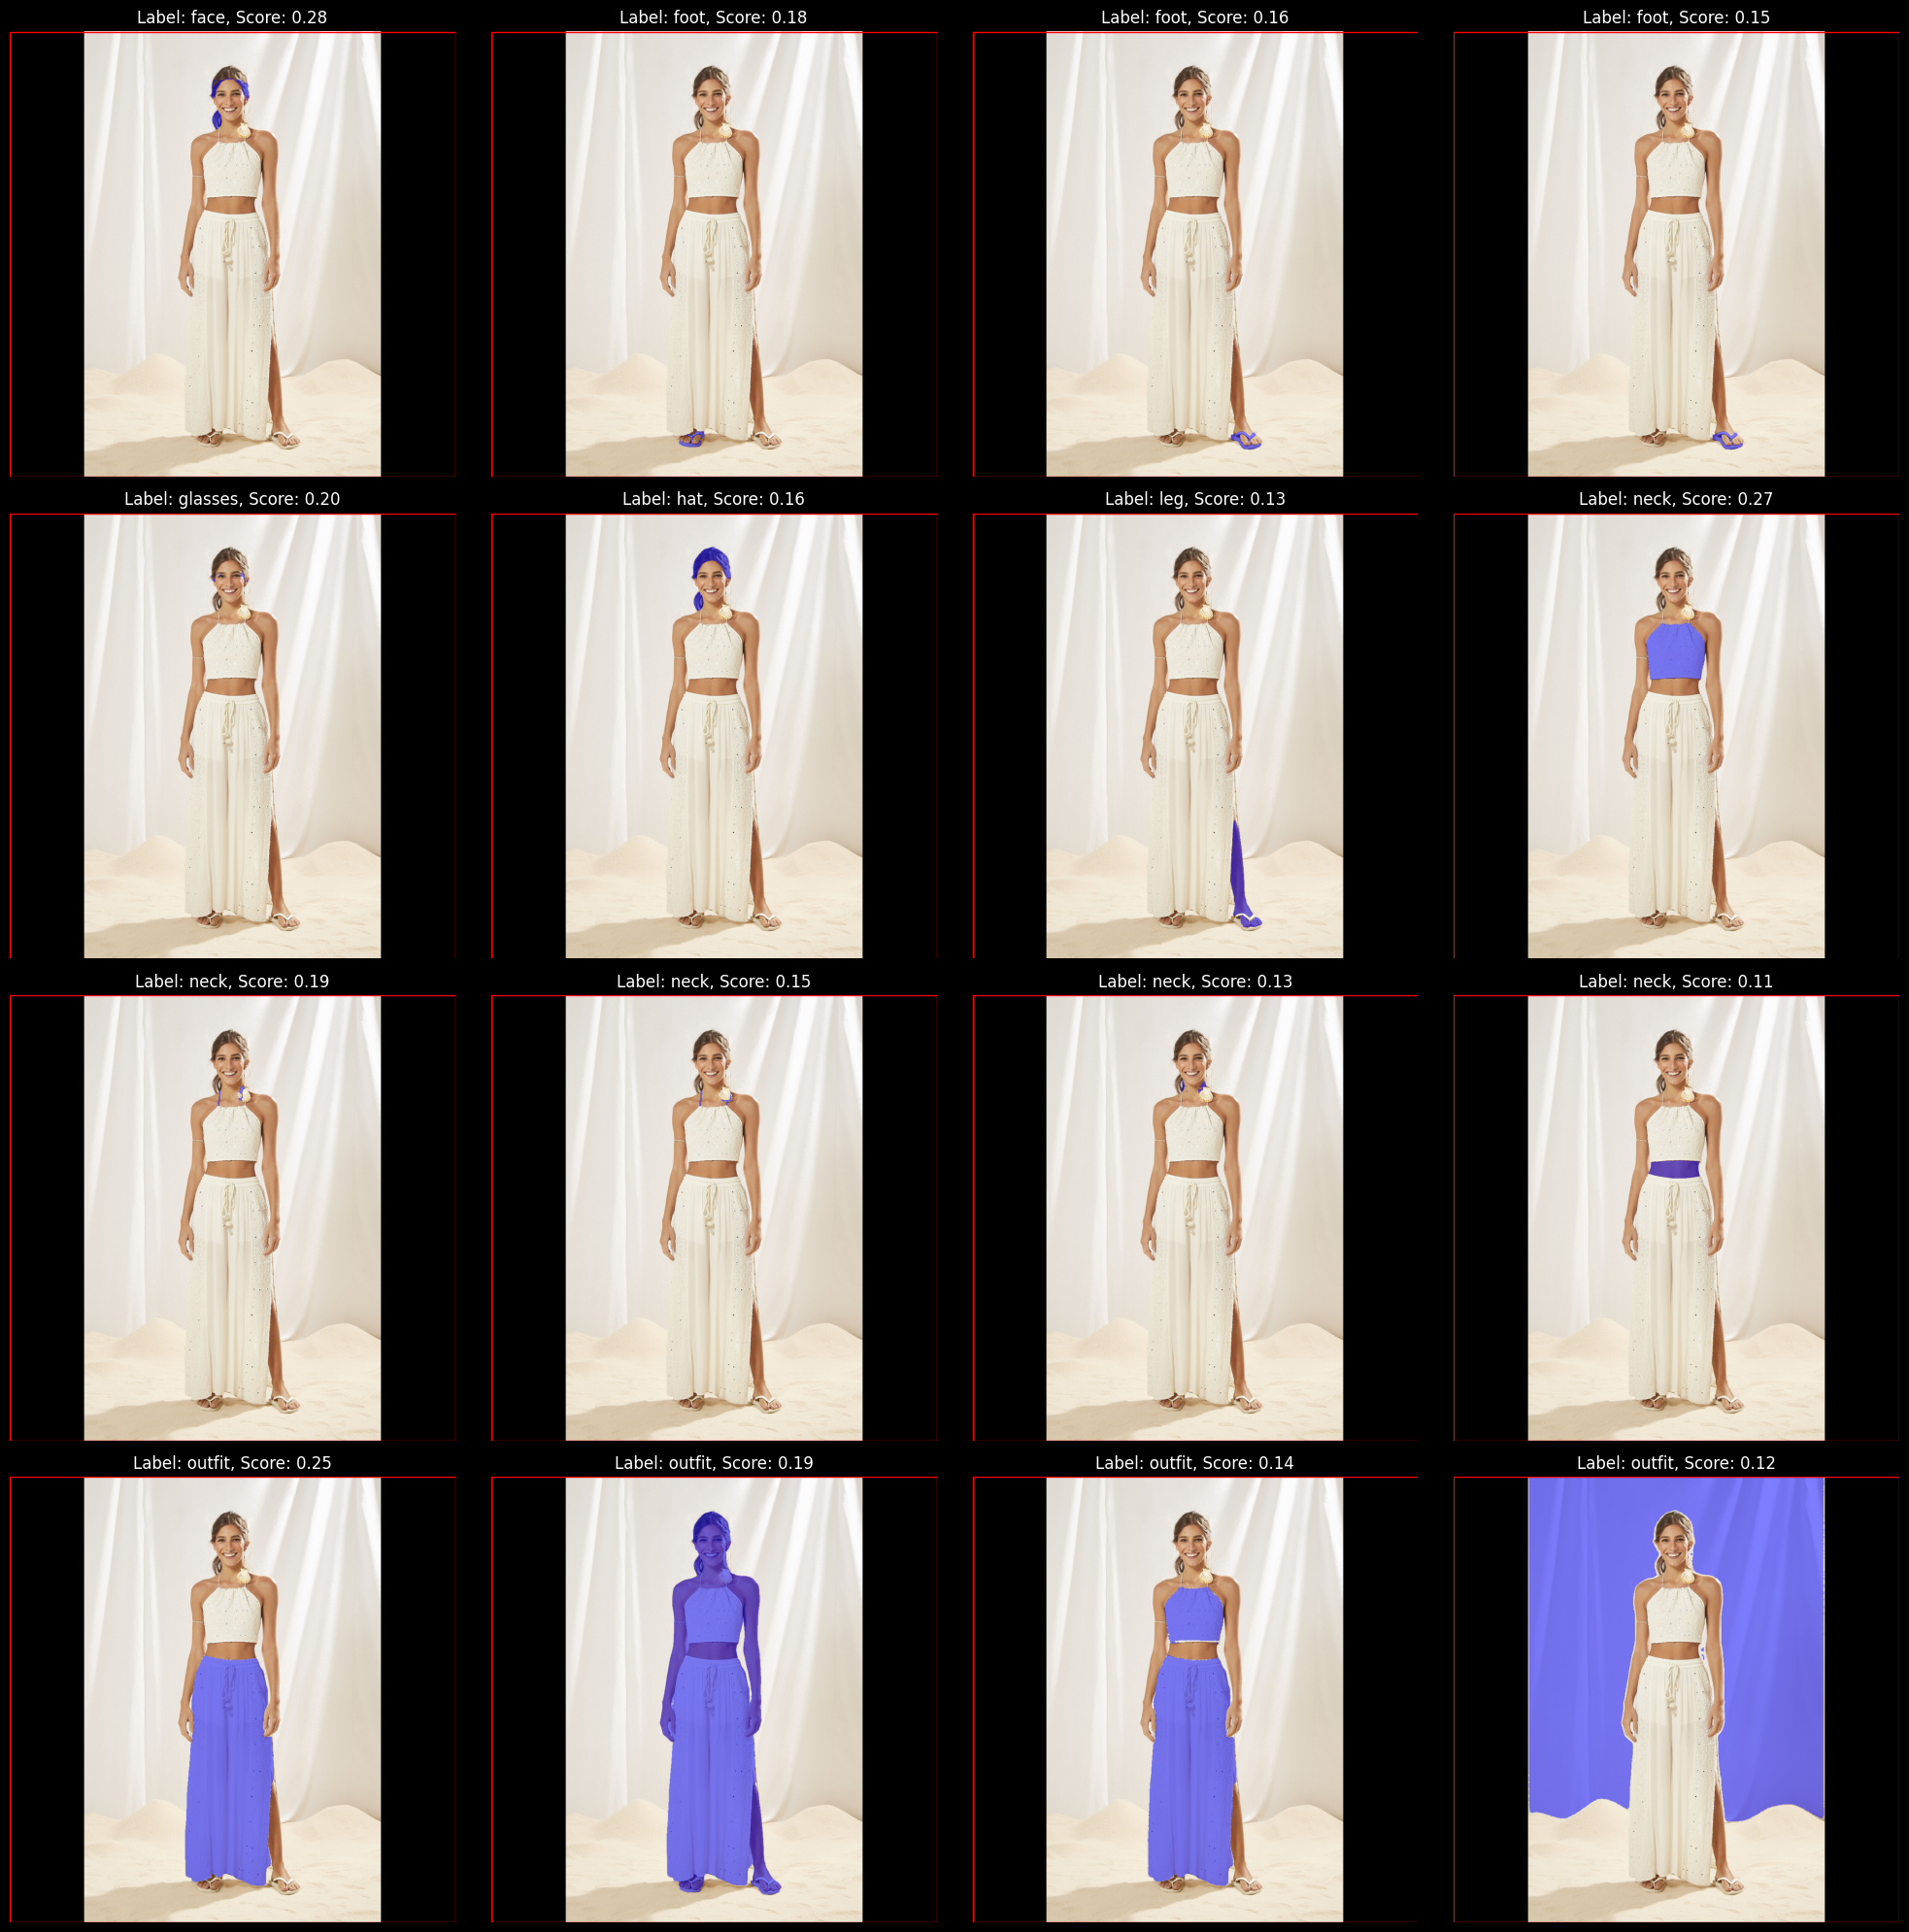

In [56]:
sam_results = get_masks(text_prompt, [image], labels_dict, size=1024, box_threshold=0.1)
sam_results.display_results()

In [43]:
size = 1024
image_paths = [image]

images = [load_resize_image(im, size) for im in image_paths]

# Get the boxes from the prompts using DINO
dino_results = get_dino_results(images, text_prompt, device, box_threshold=0.1)
print(f"Boxes: {dino_results.boxes}")

Boxes: [tensor([[ 467.5218,  108.9946,  541.3405,  211.0975],
        [ 439.9546,  222.6746,  583.0574,  386.6266],
        [ 400.5085,  409.1207,  610.5189,  942.7355],
        [ 470.2224,  137.4369,  535.8641,  156.0124],
        [ 478.9093,  195.8436,  533.9001,  247.6857],
        [ 384.6201,   79.0824,  671.9050,  961.0455],
        [ 428.1246,  912.9209,  490.5538,  956.4225],
        [ 593.7876,  915.8483,  668.0737,  961.4115],
        [ 457.7468,   78.3838,  553.9940,  228.8225],
        [ 462.6306,  221.8277,  572.7651,  257.5097],
        [ 593.5776,  895.6730,  668.1207,  962.0467],
        [ 398.4576,  220.8891,  623.4885,  943.7863],
        [ 590.9633,  700.5600,  668.0276,  962.1606],
        [ 480.2962,  190.1016,  536.1992,  225.2318],
        [ 172.2408,    3.6978,  857.2499, 1020.5648],
        [ 446.3053,  377.5775,  569.0432,  423.2465]])]


Label: neck


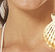

In [55]:
from segment.sam_results import format_boxes
phrases = dino_results.phrases
num = 4
phrase = phrases[0][num]
boxes = format_boxes(dino_results.boxes)

box = boxes[0][num]
print(f"Label: {phrase}")
images[0].crop(box)


In [51]:
boxes[0]

[[467.5217590332031,
  108.99456787109375,
  541.3404541015625,
  211.09750366210938],
 [439.95458984375, 222.6746063232422, 583.057373046875, 386.62664794921875],
 [400.5084533691406, 409.1207275390625, 610.5189208984375, 942.7354736328125],
 [470.222412109375, 137.43690490722656, 535.8641357421875, 156.01242065429688],
 [478.9093322753906, 195.8435821533203, 533.900146484375, 247.6857147216797],
 [384.6201171875, 79.0823974609375, 671.905029296875, 961.0455322265625],
 [428.12457275390625, 912.9208984375, 490.5538330078125, 956.4224853515625],
 [593.78759765625, 915.8483276367188, 668.07373046875, 961.4114990234375],
 [457.746826171875, 78.38375091552734, 553.9940185546875, 228.82254028320312],
 [462.6305847167969, 221.82766723632812, 572.76513671875, 257.50970458984375],
 [593.57763671875, 895.6730346679688, 668.1206665039062, 962.0466918945312],
 [398.45758056640625,
  220.88912963867188,
  623.4884643554688,
  943.7862548828125],
 [590.9633178710938, 700.5599975585938, 668.0276489